# Calculate the interpolating function based on the data points
## Chebyshev Barycentric Interpolation

\begin{align}
num\_samples = t/N
\end{align}

In [1]:
# import the interpolation code
from scripts.algo.chebyshev import chebyshev_barycentric_interp_point as interp
from scripts.algo.chebyshev import chebyshev_nodes
# import the QPE code
from scripts.algo.qdrift_qpe import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def interp_qpe(N, T, num_qubits, eigenstate, pauli_list):
    """
    Return the list of points from the interpolation of QPE
    Args:
        N: number of points to interpolate
        T: time
        num_qubits: number of qubits
        eigenstate: eigenstate of the Hamiltonian
        pauli_list: list of pauli decomposition of the Hamiltonian

    Returns:
        the list of Chebyshev nodes and the list of interpolating points
    """
    nodes = chebyshev_nodes(N)  # N chebyshev nodes
    estimates = []  # estimation at each chebyshev node
    # iterate over each node
    for node in nodes:
        num_samples = int(np.ceil(np.abs(T / node)))  # number of samplings
        results, vlist = qdrift_qpe(pauli_list, T, num_samples, num_qubits, eigenstate)  # run QDRIFT + QPE
        estimates.append(sum(results))  # append the estimate
    
    return nodes, estimates

#### Basic setup for the workflow (QDRIFT - QPE - Interpolation)

In [9]:
# list of data point numbers used in the numerical experiments
START = 4  # the minimum data points
END = 8  # the maximum data points
N_list = range(START, END + 1, 2)  # START, START + 2, START + 4, ... , END - 2, END

# domain of the plot
domain = np.linspace(-1, 1, 200) # Domain for extrapolation

# parameters for QDRIFT and QPE
TIME = 10  # simulation time
N_QUBITS = 1  # number of qubits of the circuit
N_TERMS = 5  # number of pauli terms 

pauli_string = random_pauli_string(N_QUBITS, N_TERMS)  # generate a random pauli string
H = sum(coeff * term.to_matrix() for coeff, term in pauli_string)
eigenvalues, eigenvectors = scipy.linalg.eigh(H)
eigenstate = eigenvectors[:, np.argmin(eigenvalues)]
ground_energy = eigenvalues[0]

print(f"Number of Qubits: {N_QUBITS}")
print(f"Number of Terms: {N_TERMS}")
print(f"Terms: {[term for _, term in pauli_string]}")
print(f"Coefficients: {[coeff for coeff, _ in pauli_string]}")
print(f"Correct Eig:{ground_energy}")  
        

Number of Qubits: 1
Number of Terms: 5
Terms: [Pauli('X'), Pauli('X'), Pauli('Z'), Pauli('X'), Pauli('Z')]
Coefficients: [0.3937015959317357, 0.1287315663315265, 0.9816264506219617, 0.4601661160941457, 0.013426416794132479]
Correct Eig:-1.398438969273057


#### Execute the workflow for each number of interpolation nodes

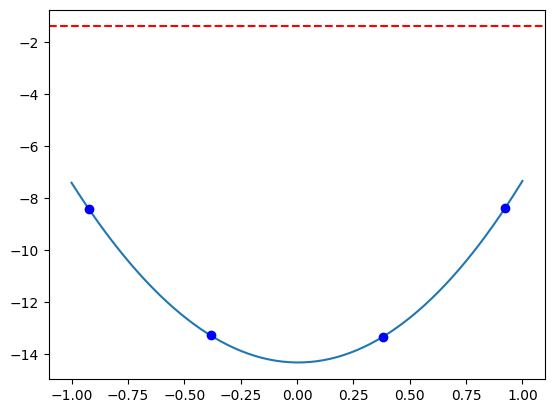

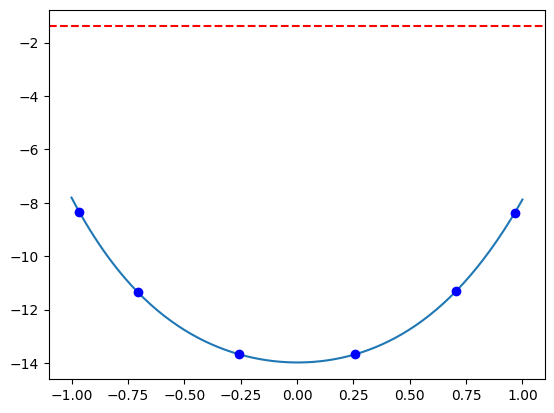

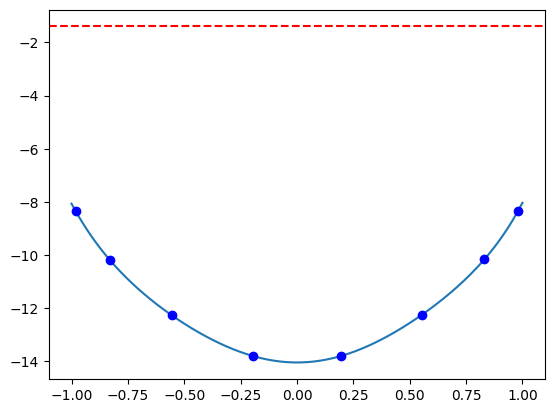

In [10]:
# iterate over independent numerical experiment
for N in N_list:
    plt.figure()  # new plot
    nodes, y = interp_qpe(N, TIME, N_QUBITS, eigenstate, pauli_string)  # run workflow
    plt.plot(domain, [interp(x, N, y) for x in domain])
    plt.plot(nodes, y, 'bo')
    plt.axhline(ground_energy, color='r', linestyle='--')
    plt.show()

### Okay... seems there is some problems in QPE algorithm... but the overall shape of the interpolation looks smooth!
### The interpolation can be done only on one side and mirrored to decrease the runtime by half.